# CASSIOPE-FAI-Map-Projection
***

**Tutorial :** This tutorial explains how to visualize data from the FAI camera with various map projections.    
**Mission and Instrument :** FAI (Fast Auroral Imager) on CASSIOPE       
**Astronomical Target :** Auroral emissions    
**Primary Tools :** Python3 script     
**Tutorial Level :** Intermediate

Pictures of the Earth can be difficult to visualize, espicially the Poles. There is a variety of map projections to visualize a realistic image of the globe. The goal of this tutorial is to test map projections from the *Basemap* module of *Matplotlib* with the FAI picture. This tutorial includes two types of visualization :

1. A zoomed picture of the FAI image ;
2. A more general map with a zoomed window of the FAI image.

Here is a list of [map projections](https://matplotlib.org/basemap/api/basemap_api.html) supported by *Basemap*.

## Library

The following script uses

* *numpy* : mathematical operation and multidimensional array
* *h5py* : open .h5 files
* *pandas* : dataframe structure
* *matplotlib* : plot figures
* *basemap* : plot maps

In [41]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import pandas as pd
import h5py

## Zoomed map

We'll start with a simple function to label the latitudes and longitudes of the map depending on the projection. We will also use this function for the other visualization.

In [42]:
# Function labeling the parallels and the meridians of a map
# The label depends on the projection
# Parameters:
# m : the map (Basemap instance)
# proj : the projection id from Basemap (string)
# interPara : the interval between parallel label (float)
# interMeri : the interval between meridian label (float)
# Returns the map
def drawParaMeri(m,proj,interPara,interMeri):
    
    # If the projection is Orthographic, Near-Sided Perspective, Geostationary or Azimuthal Equidistant
    if(proj in ['ortho','nsper','geos','aeqd']):
        m.drawparallels(np.arange(-90.,120.,interPara),linewidth=0.2)
        m.drawmeridians(np.arange(0.,420.,interMeri),linewidth=0.2)
    # If the projection is Cylindrical Equal Area, Miller Cylindrical or Gall Stereographic Cylindrical
    elif(proj in ['cyl','mill','gall']):
        m.drawparallels(np.arange(-90.,120.,interPara),linewidth=0.2, labels=[1,0,0,1], fontsize=8)
        m.drawmeridians(np.arange(0.,420.,interMeri),linewidth=0.2, labels=[1,0,0,1], fontsize=8)  
    # For other projections
    else:
        m.drawparallels(np.arange(-90.,120.,interPara),linewidth=0.2, labels=[1,1,0,0], fontsize=8)
        m.drawmeridians(np.arange(0.,420.,interMeri),linewidth=0.2, labels=[0,0,1,1], fontsize=8)

    return(m)

Next, we have a function to create the map. On the map, the FAI image will be plotted with margins around.

In [43]:
# Function plotting a zoomed map
# Parameters
# ax : the ax used to create the map (Axe)
# lon : the longitude of the picture (array of float)
# lat : the latitude of the picture (array of float)
# proj : the map projection id to use (string)
# interPara : the interval between parallel label (float)
# interMeri : the interval between meridian label (float)
# lonmargins : the margins on the x-axis (longitude) (float)
# latmargins : the margins on the y-axis (latitude) (float)
# Returns the map
def createZoomedMap(ax,lon,lat,proj,interPara,interMeri,lonmargins,latmargins):
    
    # We want a small map
    width=400000
    height=200000
    minlon = np.nanmin(lon)-lonmargins
    maxlon = np.nanmax(lon)+lonmargins
    minlat = np.nanmin(lat)-latmargins
    maxlat = np.nanmax(lat)+latmargins
    
    # If the projection is Lambert Azimuthal Equal Area, Albers Equal Area, 
    # Stereographic, Equidistant Conic or Lambert Conformal
    if(proj in ['laea','aea','stere','eqdc','lcc']):
        m = Basemap(projection=proj, width=width, height=height,
                lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)  
    # If the projection is Orthographic or Near-Sided Perspective
    elif(proj in ['ortho','nsper']):
        m = Basemap(projection=proj, lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)
    # For other projections
    else:
        m = Basemap(projection=proj,lon_0=lon[139][127], lat_0=lat[139][127],ax=ax,
                    llcrnrlon=minlon, llcrnrlat=minlat, urcrnrlon=maxlon, urcrnrlat=maxlat)
    
    # Draw the coast and country lines
    m.drawcoastlines(linewidth=0.75)
    m.drawcountries(linewidth=0.75)
    
    # Map color
    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='lightgreen',lake_color='lightblue',zorder=1)
    
    # Add labels
    m = drawParaMeri(m, proj, interPara, interMeri)
    
    return(m)

Now, let's see how the image is plotted on the map.

In [44]:
# Function plotting a FAI image on a zoomed map
# Parameters :
# file : the path to the file (string)
# proj : the map projection id to use (string)
# title : title of the figure (string)
# pct : top percentage brightness values to plot in white (default=0.01) (float)
# interPara : the interval between parallel label (default=2.) (float)
# interMeri : the interval between meridian label (defualt-5.) (float)
# Returns nothing
def plotZoomedMap(file, proj, title, lonmargins=2., latmargins=1., pct=0.01, interPara=1., interMeri=2.):
    
    # List of the supported projection of this script
    supportedProjection = ['ortho','nsper','cyl','mill', 'gall', 'stere', 'aea',
                           'eqdc','aeqd','lcc','laea']
    # If it's a different projection, stop
    if(proj not in supportedProjection):
        print("\nCette projection n'est pas supportée ou pas recommandée")
        return()
    
    # Open the file and extract the latitudes, longitudes, image and conversion factor
    with h5py.File(file, 'r') as f:
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys)
        conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])
        image = np.array(f.get('FAI Image'))/conversion
        lat = np.array(f.get('Pixel Latitudes'))
        lon = np.array(f.get('Pixel Longitudes'))
    
    # Remove the last row and column, since they only indicate 
    # the bottom right corner of the image
    lat = np.delete(lat,lat.shape[0]-1,0) 
    lat = np.delete(lat,lat.shape[1]-1,1) 
    lon = np.delete(lon,lon.shape[0]-1,0) 
    lon = np.delete(lon,lon.shape[1]-1,1)
    
    # Create the figure and add the title
    fig = plt.figure(figsize=(7,4),dpi=150)
    fig.suptitle(title)
    
    # Create the ax and define the margins
    ax = plt.subplot(111)
    plt.subplots_adjust(left=0.1,right=0.9,top=0.88,bottom=0.05,wspace=0.15,hspace=0.05)
    
    # Create the map
    m = createZoomedMap(ax,lon,lat,proj,interPara,interMeri,lonmargins,latmargins)
    
    # Create the norm of the colorbar
    n = int(image.size*pct)
    ind = np.argpartition(image.flatten(), -n)[-n:]
    inf = min(image.flatten()[ind])
    norm = colors.Normalize(vmin=np.nanmin(image),vmax=inf)
    
    if proj in ['ortho','nsper']:
        lx,ly=m(np.nanmin(lon)-lonmargins,np.nanmin(lat)-latmargins)
        ux,uy=m(np.nanmax(lon)+lonmargins,np.nanmax(lat)+latmargins)
        ax.set_xlim(lx,ux)
        ax.set_ylim(ly,uy)
    
    # Plot the picture and add colorbar
    sc = m.scatter(lon,lat,c=image,cmap='binary_r',norm=norm, latlon=True,zorder=10)
    c = fig.colorbar(sc,orientation='horizontal', ax=ax, pad=0.05, shrink=0.75, )
    c.ax.tick_params(labelsize=8)
    c.set_label("Brightness (Data Unit)", fontsize=9) 
    
    return()    

Let's test it out!

In [45]:
file='FAI_lv1_NIR_20210111_062703_062703_6.0.0.h5'

**Rectangular maps**

()

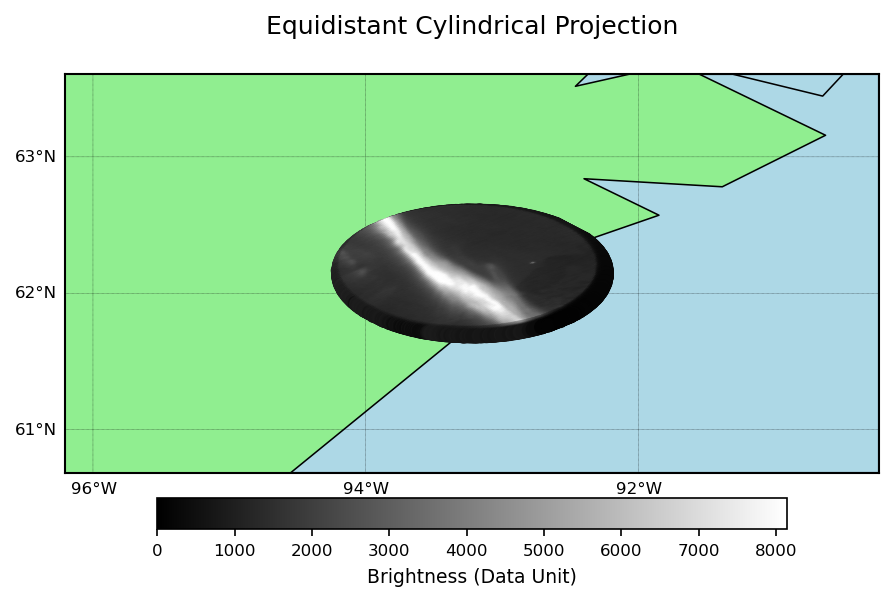

In [46]:
plotZoomedMap(file,'cyl', 'Equidistant Cylindrical Projection')

()

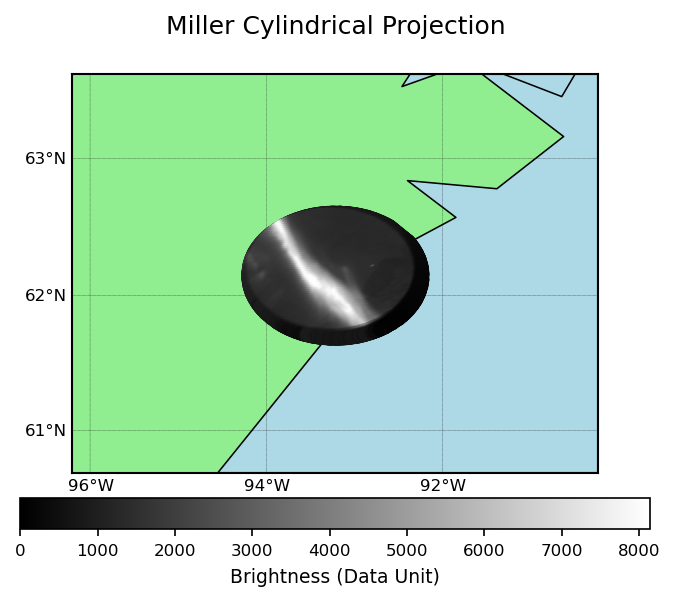

In [47]:
plotZoomedMap(file,'mill', 'Miller Cylindrical Projection')

()

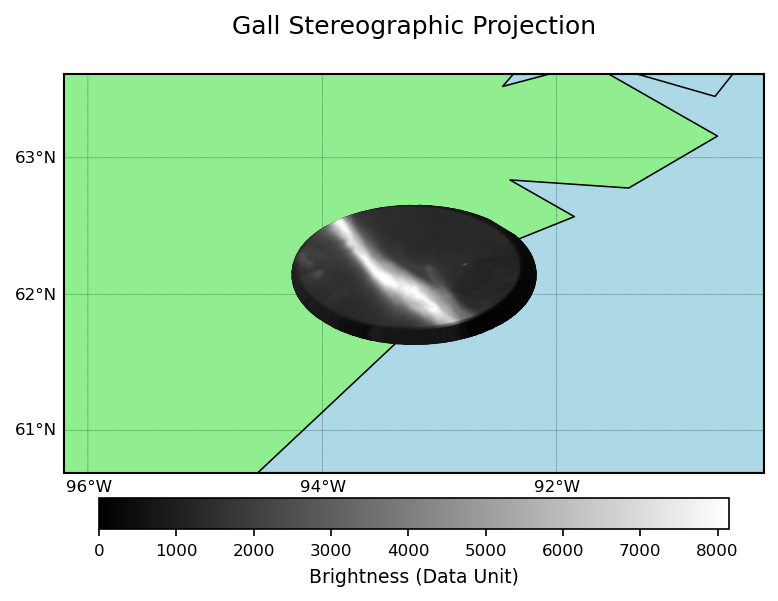

In [48]:
plotZoomedMap(file, 'gall', 'Gall Stereographic Projection')

**Globe maps**

()

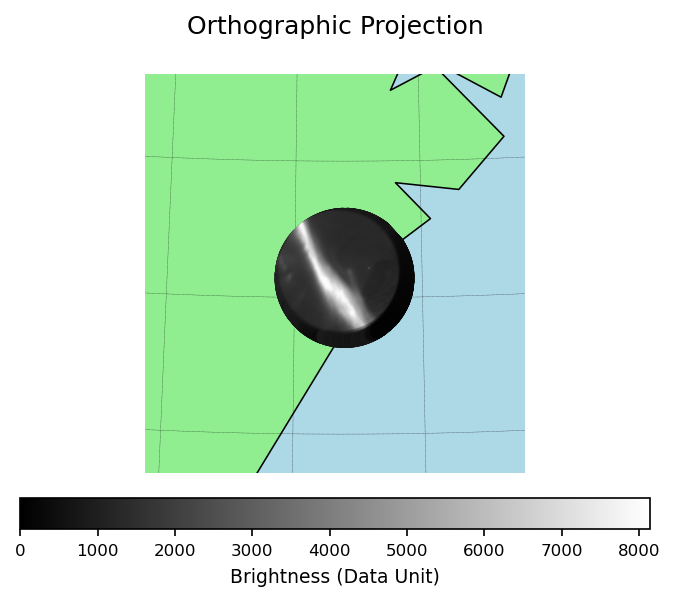

In [49]:
plotZoomedMap(file, 'ortho', 'Orthographic Projection')

()

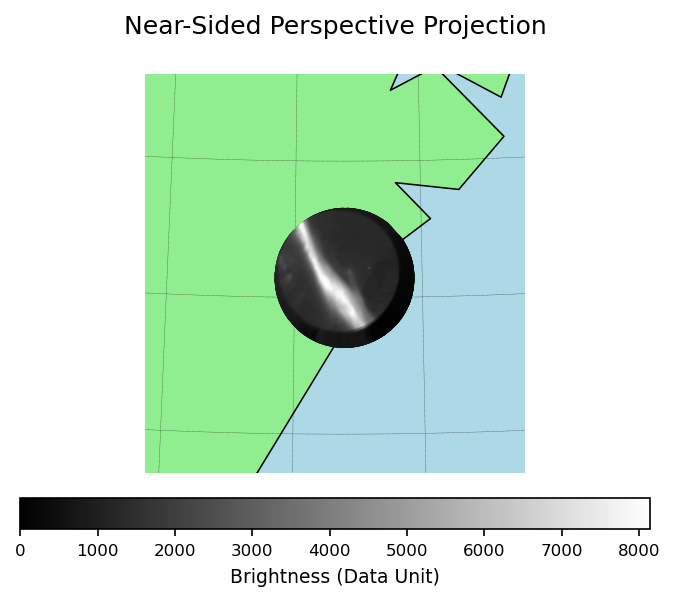

In [50]:
plotZoomedMap(file, 'nsper', 'Near-Sided Perspective Projection')

()

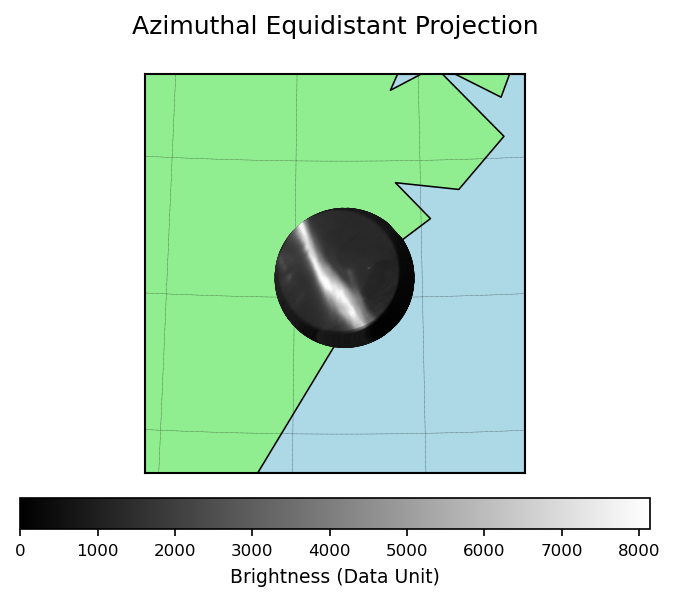

In [51]:
plotZoomedMap(file, 'aeqd', 'Azimuthal Equidistant Projection')

**Rectangulair maps with transformation**

()

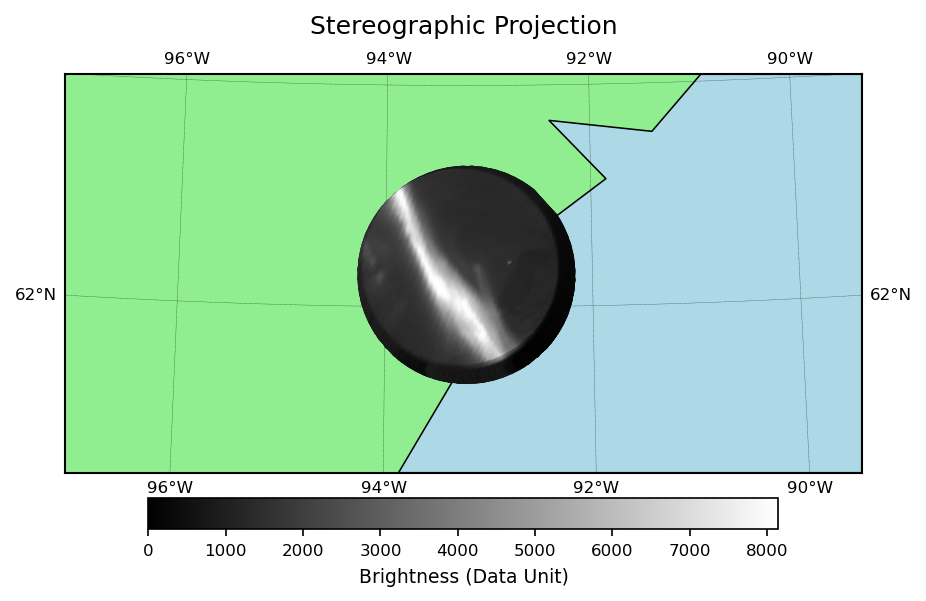

In [52]:
plotZoomedMap(file, 'stere', 'Stereographic Projection')

()

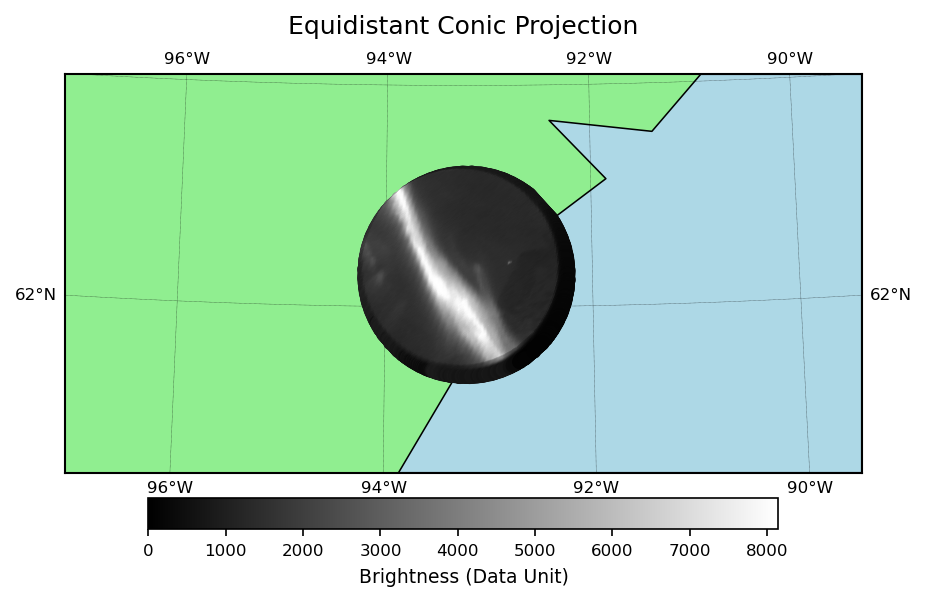

In [53]:
plotZoomedMap(file, 'eqdc', 'Equidistant Conic Projection')

()

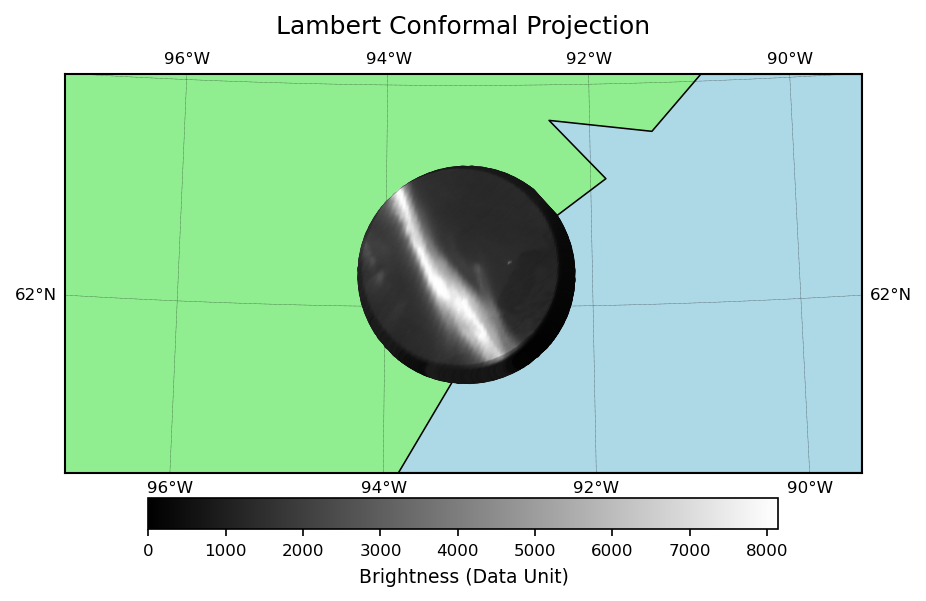

In [54]:
plotZoomedMap(file, 'lcc', 'Lambert Conformal Projection')

()

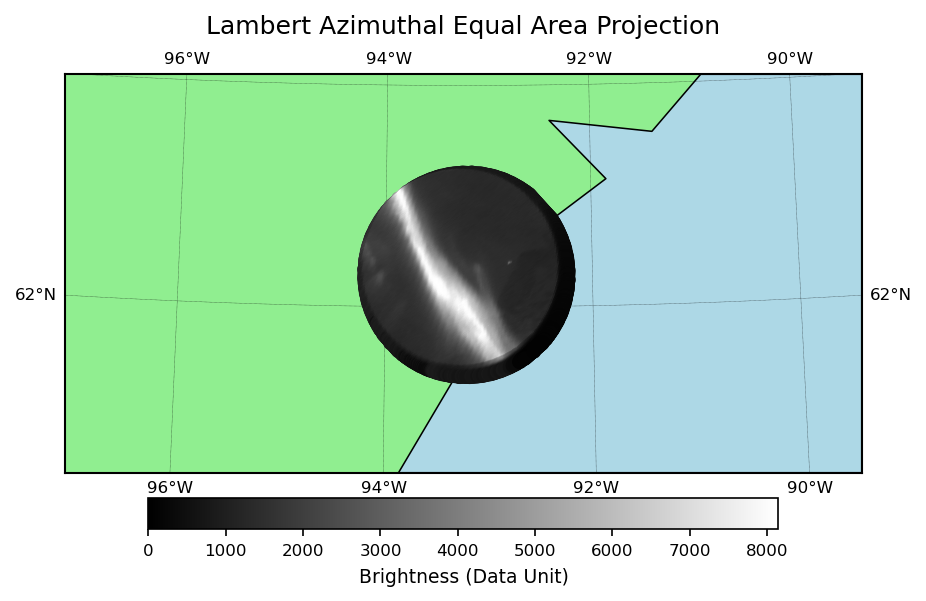

In [55]:
plotZoomedMap(file, 'laea', 'Lambert Azimuthal Equal Area Projection')

()

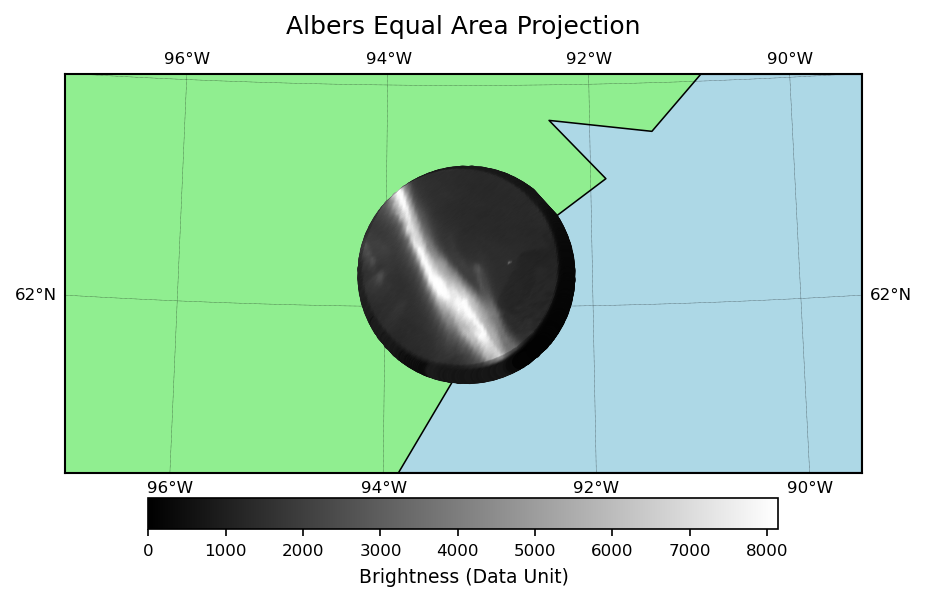

In [56]:
plotZoomedMap(file, 'aea', 'Albers Equal Area Projection')

In [57]:
plt.close('all')

## General Map

The function to label the parrallels and meridians is the same as above. The one to create the maps is similar.

In [58]:
# Function to plot a general map
# Parameters
# ax : the ax used to create the map (Axe)
# lon : the longitude of the picture (array of float)
# lat : the latitude of the picture (array of float)
# proj : the map projection id to use (string)
def createMap(ax,lon,lat,proj):
    
    # If the projection is Lambert Azimuthal Equal Area, Albers Equal Area, 
    # Stereographic, Equidistant Conic or Lambert Conformal
    if(proj in ['laea','aea','stere','eqdc','lcc']):
        m = Basemap(projection=proj, width=12000000, height=7500000,
                    lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)
    # If we use a specific projection of the north pole 
    elif(proj in ['npstere', 'npaeqd', 'nplaea']):
        m = Basemap(projection=proj, boundinglat=10,
                    lon_0=lon[139][127], ax=ax)  
    # If we use a specific projection of the south pole
    elif(proj in ['spstere','spaeqd', 'splaea']):
        if(lon[139][127]>=0):
            m = Basemap(projection=proj, boundinglat=-10,lon_0=lon[139][127]-180, ax=ax) 
        else:
            m = Basemap(projection=proj, boundinglat=-10,lon_0=lon[139][127]+180, ax=ax)
    # For other projections
    else:
        m = Basemap(projection=proj,lon_0=lon[139][127], lat_0=lat[139][127],ax=ax)
       
    # Add coaslines and countries
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    
    return(m) 

The function to plot the FAI picture on the map is also similar, but we add a zoomed window.

In [59]:
# Function to plot a zoomed map on top of a general map
# Parameters :
# file : the path to the file (string)
# proj : the map projection id to use (string)
# title : title of the figure (string)
# zoom : zoom to apply (int)
# pct : top percentage brightness values to plot in white (default=0.01) (float)
# interPara : the interval between parallel label (default=30.) (float)
# interMeri : the interval between meridian label (defualt-60.) (float)
def plotGeneralMap(file,proj,title,zoom,pct=0.01,interPara=30.,interMeri=60.):
    
    # List of the supported projection of this script
    supportedProjection = ['ortho','nsper','cyl','mill', 'gall', 'stere', 'aea',
                           'eqdc','aeqd','npstere','spstere','npaeqd', 'spaeqd',
                           'lcc','laea','nplaea','splaea']
    # If it's a different projection, stop
    if(proj not in supportedProjection):
        print("\nCette projection n'est pas supportée ou pas recommandée")
        return()
    
     # Open the file and extract the latitudes, longitudes, image and conversion factor
    with h5py.File(file, 'r') as f:
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys)
        conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])
        image = np.array(f.get('FAI Image'))/conversion
        lat = np.array(f.get('Pixel Latitudes'))
        lon = np.array(f.get('Pixel Longitudes'))
    
    # Remove the last row and column, since they only indicate 
    # the bottom right corner of the image
    lat = np.delete(lat,lat.shape[0]-1,0) 
    lat = np.delete(lat,lat.shape[1]-1,1)  
    lon = np.delete(lon,lon.shape[0]-1,0) 
    lon = np.delete(lon,lon.shape[1]-1,1)
    
    # Create the figure and add title
    fig = plt.figure(figsize=(7,4),dpi=150)
    fig.suptitle(title)
    # Create the axe and define the margins
    ax = plt.subplot(111)
    plt.subplots_adjust(left=0.1,right=0.9,top=0.88,bottom=0.05,wspace=0.15,hspace=0.05)
    # Create and label the general map
    m = createMap(ax,lon,lat,proj)
    m = drawParaMeri(m, proj, interPara,interMeri)
    contour = m.drawmapboundary(linewidth=1,color='k')
    contour.set_clip_on(False)
    
    # Create the norm of the colorbar
    n = int(image.size*pct)
    ind = np.argpartition(image.flatten(), -n)[-n:]
    inf = min(image.flatten()[ind])
    norm = colors.Normalize(vmin=np.nanmin(image),vmax=inf)
    
    # Plot the image and add the colorbar
    sc = m.scatter(lon,lat,c=image,cmap='binary_r',norm=norm, latlon=True)
    c = fig.colorbar(sc,orientation='horizontal', ax=ax, pad=0.05, shrink=0.75, )
    c.ax.tick_params(labelsize=8)
    c.set_label("Brightness (Data Unit)", fontsize=9) 
    
    # Create the axis with the zoomed map
    axins = zoomed_inset_axes(ax, zoom, loc='center',bbox_to_anchor=(800,375))
    # Create the zoomed map
    m2 = createMap(axins,lon,lat,proj)
    # Zoomed on the domain of the image
    lx,ly=m2(np.nanmin(lon)-0.5,np.nanmin(lat)-0.25)
    ux,uy=m2(np.nanmax(lon)+0.5,np.nanmax(lat)+0.25)
    axins.set_xlim(lx,ux)
    axins.set_ylim(ly,uy) 
    mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
    # Plot the image
    m2.scatter(lon,lat,c=image,cmap='binary_r',norm=norm,latlon=True)
    
    return()

Let's test it out.

In [60]:
file='FAI_lv1_NIR_20190501_150819_150819_6.0.0.h5'

**Rectangular Maps**

()

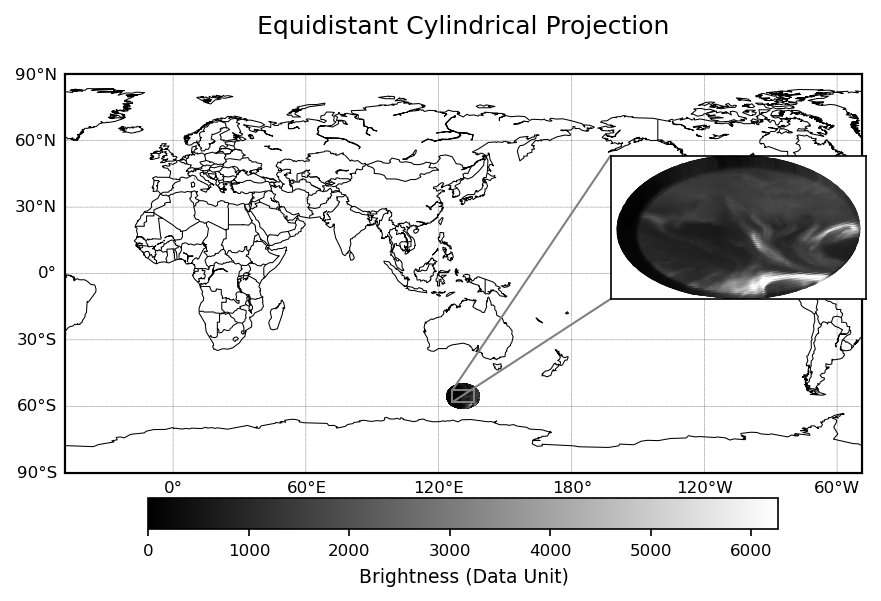

In [61]:
plotGeneralMap(file,'cyl', 'Equidistant Cylindrical Projection', 12)

()

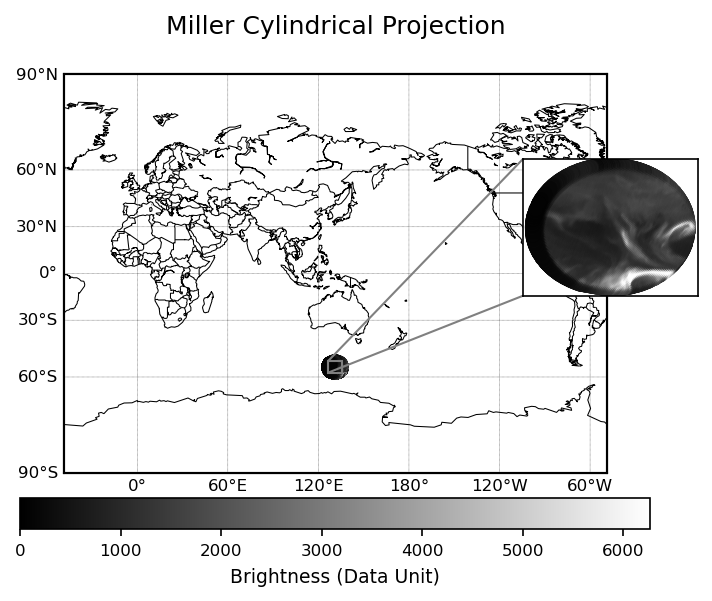

In [62]:
plotGeneralMap(file,'mill', 'Miller Cylindrical Projection', 12)

()

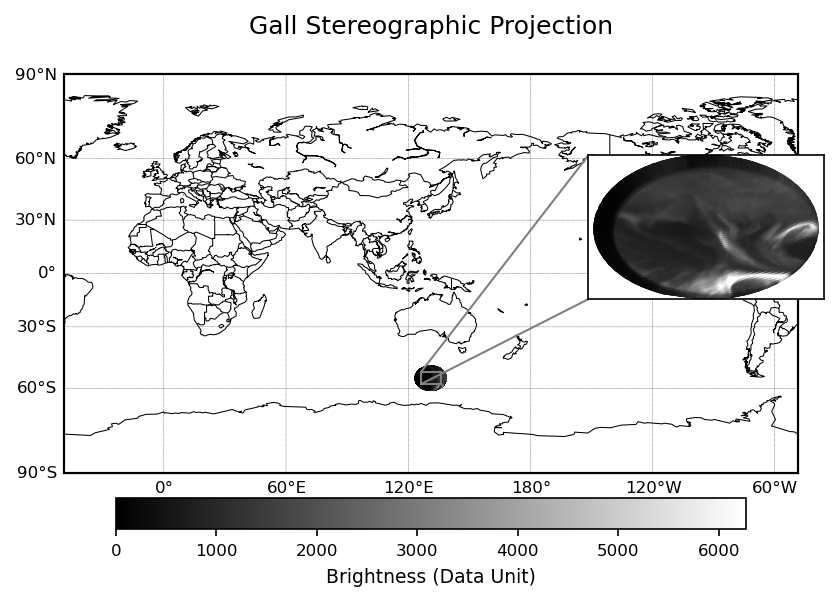

In [63]:
plotGeneralMap(file, 'gall', 'Gall Stereographic Projection', 12)

**Globe maps**

()

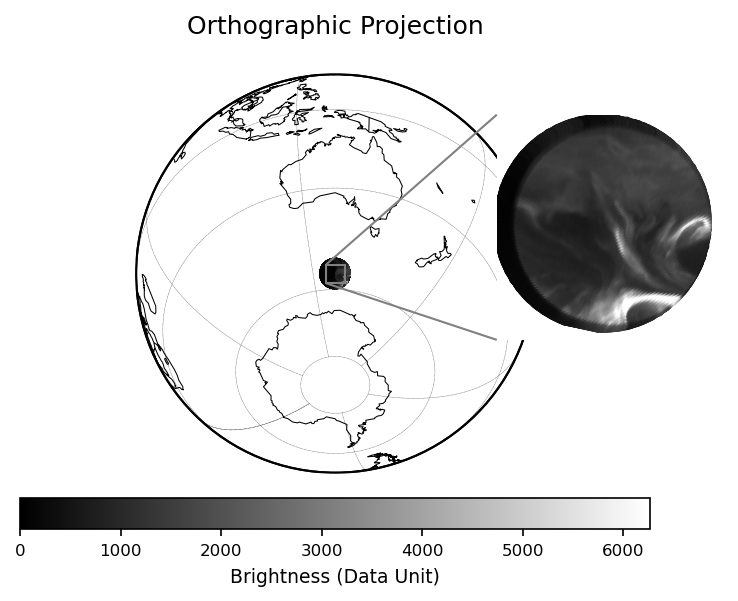

In [64]:
plotGeneralMap(file, 'ortho', 'Orthographic Projection', 12)

()

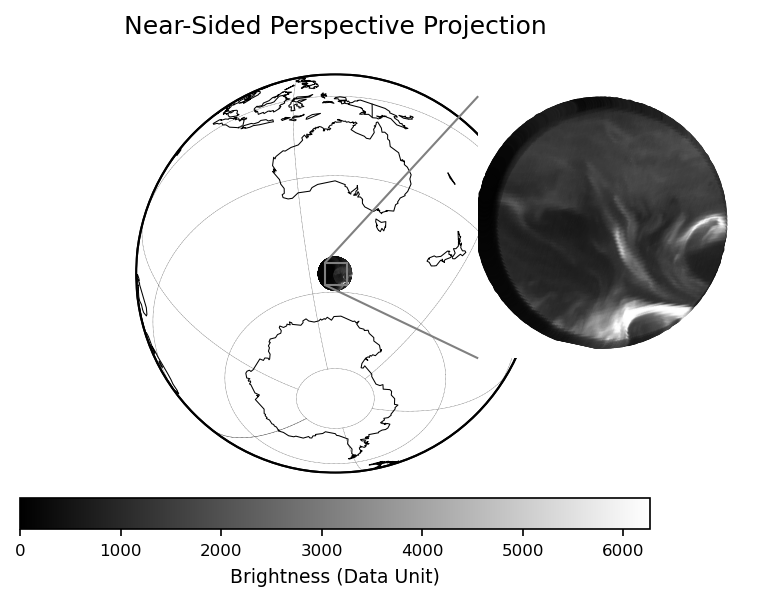

In [65]:
plotGeneralMap(file, 'nsper', 'Near-Sided Perspective Projection', 12)

()

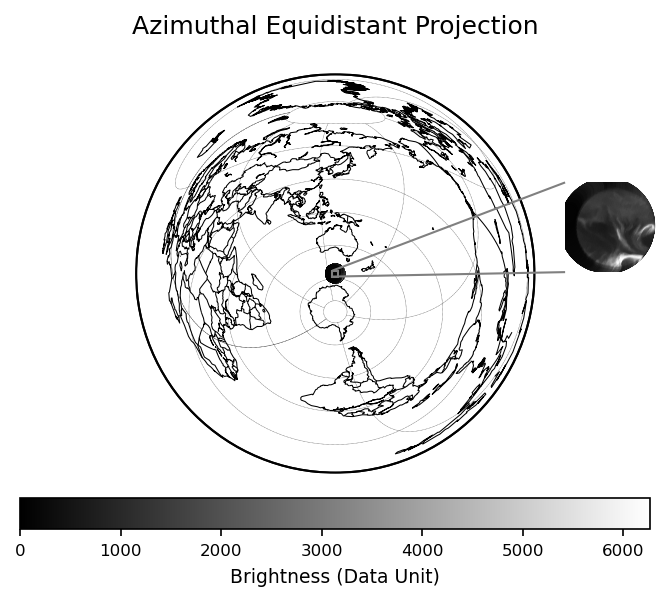

In [66]:
plotGeneralMap(file, 'aeqd', 'Azimuthal Equidistant Projection', 15)

**Rectangulare maps with transformation**

()

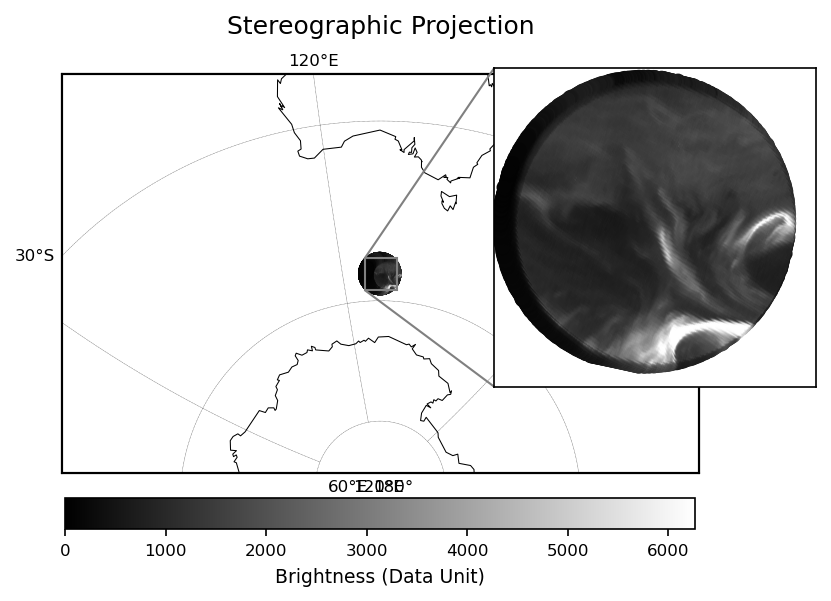

In [67]:
plotGeneralMap(file, 'stere', 'Stereographic Projection', 10)

()

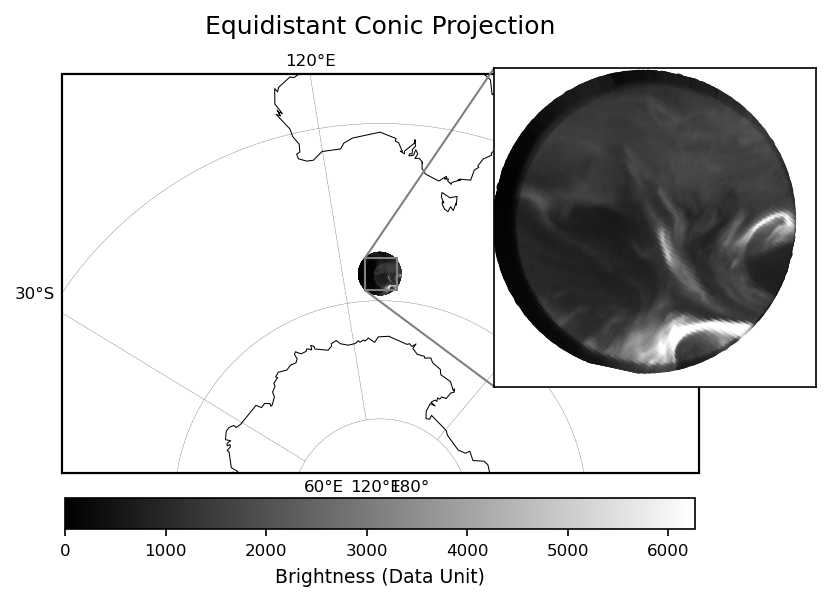

In [68]:
plotGeneralMap(file, 'eqdc', 'Equidistant Conic Projection', 10)

()

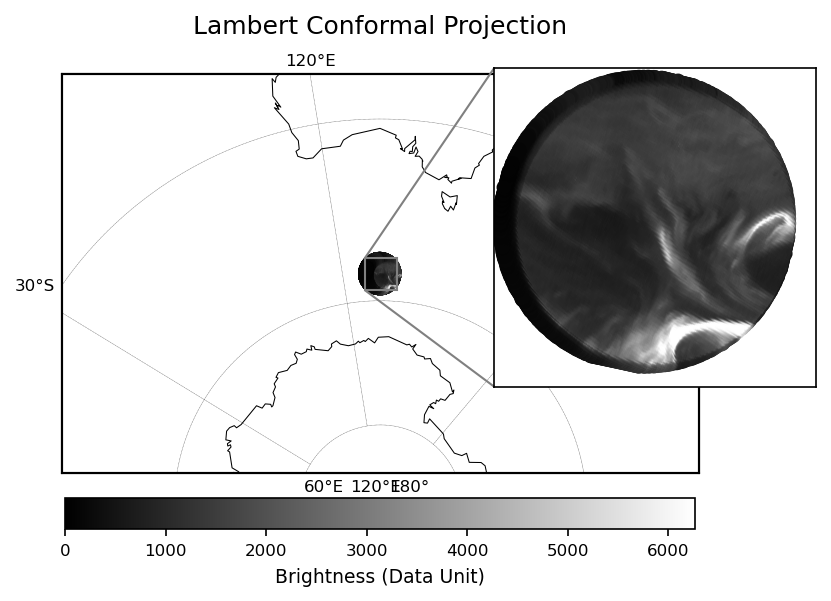

In [69]:
plotGeneralMap(file, 'lcc', 'Lambert Conformal Projection', 10)

()

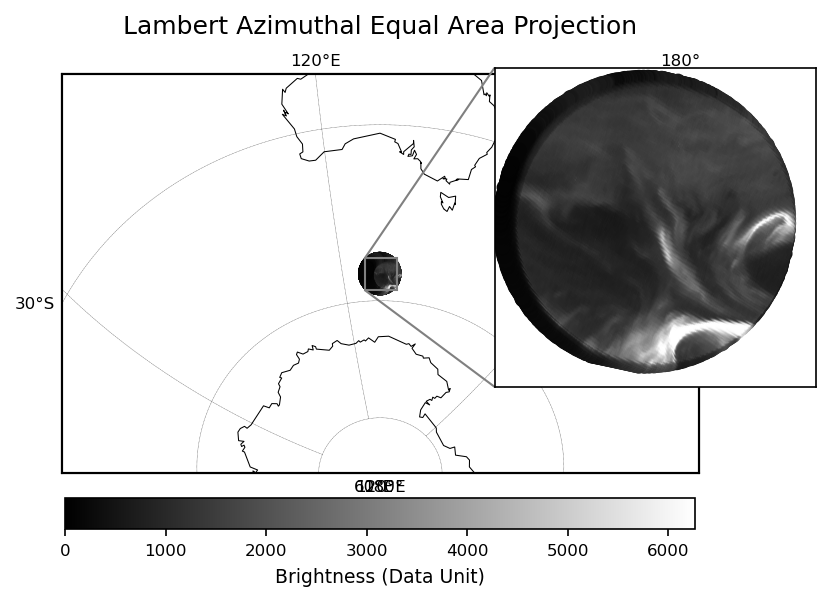

In [70]:
plotGeneralMap(file, 'laea', 'Lambert Azimuthal Equal Area Projection', 10)

()

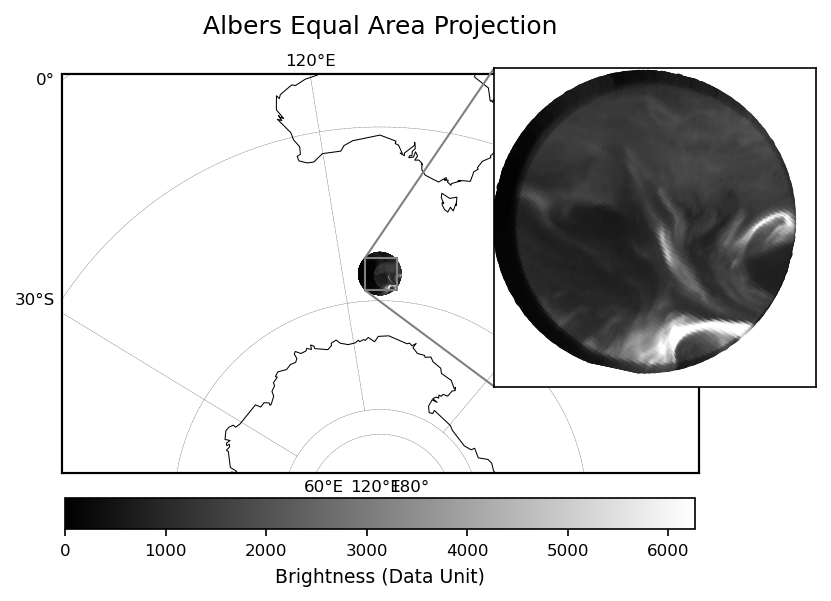

In [71]:
plotGeneralMap(file, 'aea', 'Albers Equal Area Projection', 10)

**South Pole**

()

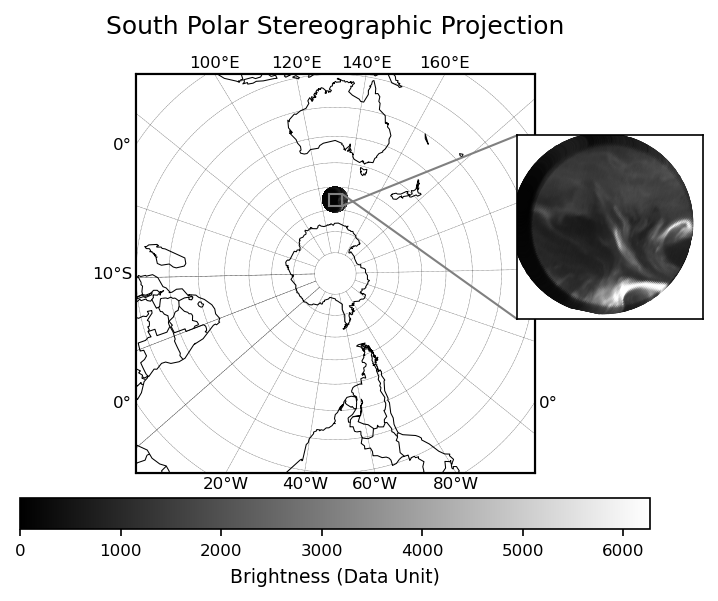

In [72]:
plotGeneralMap(file, 'spstere', 'South Polar Stereographic Projection', 15, interPara=10.,interMeri=20.)

()

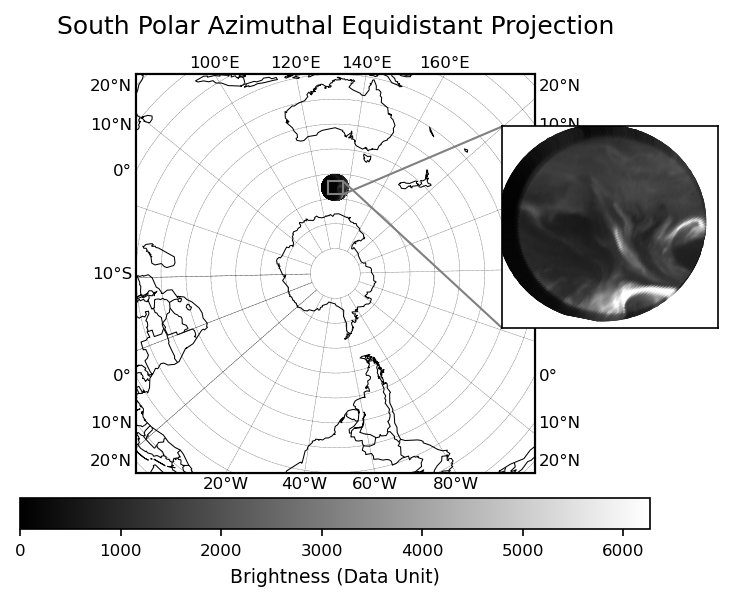

In [73]:
plotGeneralMap(file, 'spaeqd', 'South Polar Azimuthal Equidistant Projection', 15, interPara=10., interMeri=20.)

()

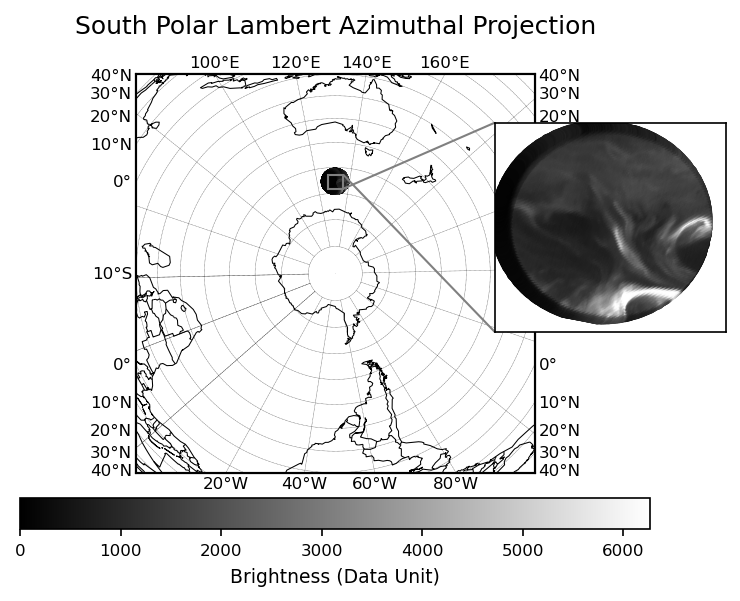

In [74]:
plotGeneralMap(file, 'splaea', 'South Polar Lambert Azimuthal Projection', 15, interPara=10.,interMeri=20.)

**North Pole**

()

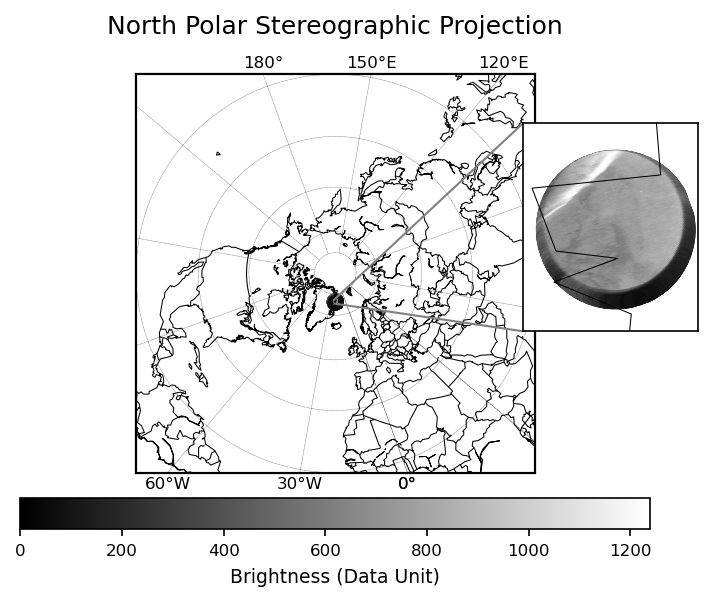

In [75]:
file='FAI_lv1_NIR_20190104_070011_070011_6.0.0.h5'
plotGeneralMap(file, 'npstere', 'North Polar Stereographic Projection', 60, interPara=20.,interMeri=30.)

()

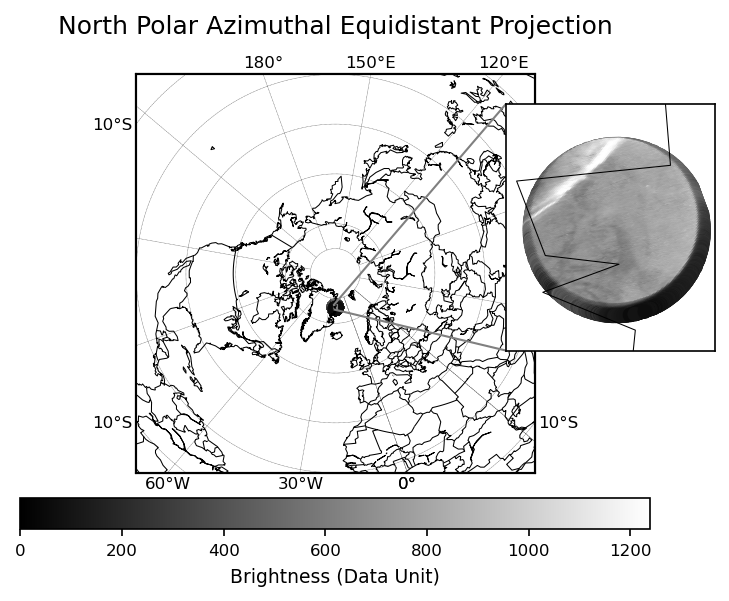

In [76]:
plotGeneralMap(file, 'npaeqd', 'North Polar Azimuthal Equidistant Projection', 60, interPara=20., interMeri=30.)

()

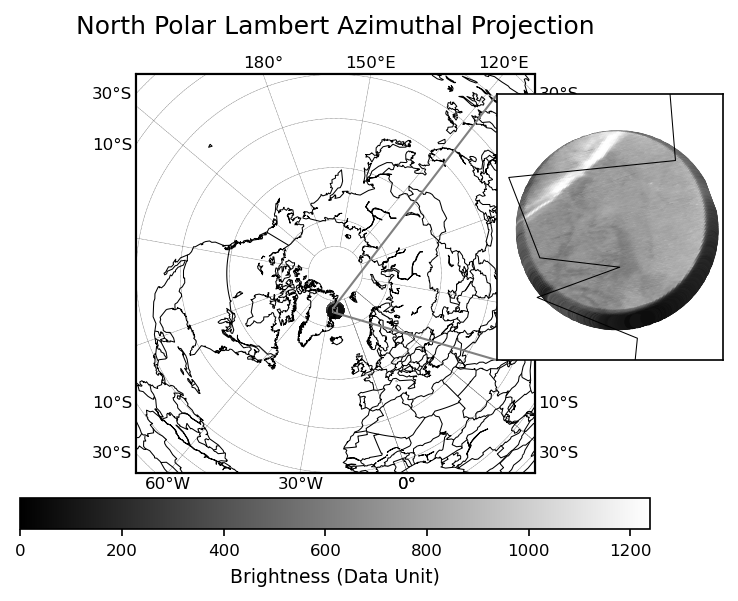

In [77]:
plotGeneralMap(file, 'nplaea', 'North Polar Lambert Azimuthal Projection', 60, interPara=20.,interMeri=30.)

In [79]:
plt.close('all')

Here's a list of other available projections in basemap but are not supported by this script, but can be added easily.

* Gnomonic Projection (gnom)
* Geostationary Projection (geos)
* Mollweide Projection (moll)
* Hammer Projection (hammer)
* Robinson Projection (robin)
* Eckert IV Projection (eck4)
* Kavrayskiy VII Projection (kav7)
* McBryde-Thomas Flat Polar Quartic (mbtfpq)
* Sinusoidal Projection (sinu)
* Cassini Projection (cass)
* Mercator Projection (merc)
* Transverse Mercator Projection (tmerc)
* Oblique Mercator Projection (omerc)
* Polyconic Projection (poly)
* Cylindrial Equal-Area Projection (cea)
* van der Grinten Projection (vandg)